Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import dask.dataframe as dd
import dask.dataframe as dd
import os
import json
from dask_ml.preprocessing import StandardScaler
from dask_ml.linear_model import LinearRegression
from dask.distributed import LocalCluster, Client
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import xgboost as xgb
import time
import pandas as pd
import matplotlib.pyplot as plt
from dask.distributed import LocalCluster, Client
from memory_profiler import memory_usage
from sklearn.linear_model import SGDRegressor


In [3]:
os.chdir('C:\\Users\\Uporabnik\\Documents\\FRI\\BD_project')


### Set up

In [ ]:
# Cluster configuration
n_workers = 5
memory_limit = '5GB'
file_type = 'parquet'

print(memory_limit)
#memory_limit = '8GB'
cluster = LocalCluster(n_workers=n_workers, memory_limit=memory_limit)

client = Client(cluster)
print(client)


5GB


c:\Users\Uporabnik\.conda\envs\bdproject\Lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 58073 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:58074' processes=5 threads=20, memory=23.28 GiB>


In [514]:
time_dict = {
    "n_workers": n_workers,
    "memory_limit": memory_limit,
    "file_type": file_type
}

In [4]:
# get to c:\Users\Uporabnik\Documents\FRI\BD_project\data\parquet_files

#DATA_DIR = '/d/hpc/projects/FRI/bigdata/students/mk75264/data/augmented'  # Update this path accordingly
DATA_DIR = 'C:/Users/Uporabnik/Documents/FRI/BD_project/data/parquet_files'

In [522]:
# read in the parquet files but only the first 10 partitions
def read_parquet_files():
    start = time.time()
    df = dd.read_parquet(DATA_DIR + '/*.parquet', engine='pyarrow', )
    end = time.time()
    print("Time to read parquet files: ", end-start)

    time_dict['read'] = end - start
    return df

mem_usage = memory_usage(read_parquet_files, max_usage=True)
df = read_parquet_files()

print(f"Peak memory usage: {mem_usage} MB")


Time to read parquet files:  0.17078852653503418
Time to read parquet files:  0.1357898712158203
Time to read parquet files:  0.15330147743225098
Peak memory usage: 671.96484375 MB


In [523]:
# Code does not work without repartitioning
df = df.repartition(npartitions=15)

In [524]:
df.dtypes

Summons Number                       string[pyarrow]
Plate ID                             string[pyarrow]
Registration State                   string[pyarrow]
Plate Type                           string[pyarrow]
Issue Date                           string[pyarrow]
Violation Code                       string[pyarrow]
Vehicle Body Type                    string[pyarrow]
Vehicle Make                         string[pyarrow]
Issuing Agency                       string[pyarrow]
Street Code1                         string[pyarrow]
Street Code2                         string[pyarrow]
Street Code3                         string[pyarrow]
Vehicle Expiration Date              string[pyarrow]
Violation Location                   string[pyarrow]
Violation Precinct                   string[pyarrow]
Issuer Precinct                      string[pyarrow]
Issuer Code                          string[pyarrow]
Issuer Command                       string[pyarrow]
Issuer Squad                         string[py

### Data preparation

In [525]:
# Columns to keep
columns_to_keep = [
    'Issue Date', 
    #'Plate ID', 
    #'Violation Code', 
    #'Registration State', #- for plotting
    #'Plate Type', 
    #'Vehicle Body Type', 
    #'Vehicle Color', 
    #'Vehicle Make', 
    #'Issuing Agency', 
    #'Violation Time', #!! change
    #'Vehicle Year', 
    #'Time First Observed', 
    'Violation County', # we have alread
    #'Street'
    #'PRCP'
]

In [526]:
df = df[columns_to_keep]
df = df.dropna()
df.head()

,Issue Date,Violation County
0,2013-07-02,NY
1,2013-07-02,NY
2,2013-07-02,NY
3,2013-07-01,NY
4,2013-07-01,NY


#TODO: We also have to select the appropriate locations here: so all, county, or most interesting streets.

In [521]:
df = df[df['Violation County'] == 'NY']
df

,Issue Date,Violation County
npartitions=15,,
,string,string
,...,...
...,...,...
,...,...
,...,...


## Grouping data

In [527]:
df = df.persist()

In [528]:
df["n_tickets"] = 1

df = df.groupby(["Issue Date", "Violation County"]).sum()

df_pred = df.compute().reset_index()
# time: 79s

CancelledError: ('repartitiontofewer-28f432365cbead3dd3989f18d8d84ab0', 0)

In [529]:
df_pred.head()

,Issue Date,Violation County,n_tickets,Schools,Businesses,Attractions,day,month,year,day_of_week
0,2013-07-01,BX,13,0.239906,0.087786,0.065147,1,7,2013,0
1,2013-07-01,K,8,0.306612,0.178958,0.169381,1,7,2013,0
2,2013-07-01,NY,101,0.200702,0.143849,0.631922,1,7,2013,0
3,2013-07-01,Q,5,0.199532,0.162811,0.081433,1,7,2013,0
4,2013-07-01,R,1,0.042715,0.032923,0.052117,1,7,2013,0


In [530]:
df_pred.sort_values(by="n_tickets")

,Issue Date,Violation County,n_tickets,Schools,Businesses,Attractions,day,month,year,day_of_week
19572,2024-06-17,BX,1,0.239906,0.087786,0.065147,17,6,2024,0
19556,2024-06-06,K,1,0.306612,0.178958,0.169381,6,6,2024,3
19557,2024-06-06,Q,1,0.199532,0.162811,0.081433,6,6,2024,3
19558,2024-06-07,K,1,0.306612,0.178958,0.169381,7,6,2024,4
10912,2019-06-27,Q,1,0.199532,0.162811,0.081433,27,6,2019,3
...,...,...,...,...,...,...,...,...,...,...
2812,2015-01-16,NY,27386,0.200702,0.143849,0.631922,16,1,2015,4
2842,2015-01-22,NY,27851,0.200702,0.143849,0.631922,22,1,2015,3
2797,2015-01-13,NY,28294,0.200702,0.143849,0.631922,13,1,2015,1
2807,2015-01-15,NY,28913,0.200702,0.143849,0.631922,15,1,2015,3


In [531]:
df = df_pred

## Adding augmented data

In [532]:
# data directories
DATA_DIR = 'data/parking-violations/' # original data
PARQUET_DIR = "data/parquet_files" # partitioned files of augmented data
WEATHER_DIR = 'data/weather/'
AUGMENTED_DIR = 'data/augmented/' # original + augmented data
SCHOOLS_DIR = 'data/schools/'
ATTRACTIONS_DIR = 'data/attractions/'
BUSINESS_DIR = 'data/businesses/'
CRIME_DIR = 'data/crime/'
EVENTS_DIR = 'data/events/'

### Schools:

In [533]:

with open(os.path.join(SCHOOLS_DIR, f'borough_school_counts.json'), 'r') as f:
    schools_dict = json.load(f)


In [534]:
# change key "M" to "NY"
schools_dict['NY'] = schools_dict.pop('M')
schools_dict['BX'] = schools_dict.pop('X')

In [535]:

# TO ADD BELOW IN THE LOOP: Add the number of schools in the borough where the violation occurred
df['Schools'] = df['Violation County'].map(schools_dict)

In [536]:
schools_dict

{'K': 0.30661205383265067,
 'Q': 0.19953188999414861,
 'R': 0.042715038033937974,
 'O': 0.0011702750146284377,
 'NY': 0.20070216500877705,
 'BX': 0.23990637799882972}

### Events:

In [537]:
events_df = pd.read_csv(os.path.join(EVENTS_DIR, f'events_count.csv'))

In [538]:
events_df.dtypes

date                          object
borough                       object
events_count                   int64
borough_normalized_events    float64
day_normalized_events        float64
total_events_by_borough        int64
total_events_by_day            int64
dtype: object

In [539]:
# change the date column to datetime
events_df['date'] = pd.to_datetime(events_df['date'])

In [540]:
events_df
# rename the columns to inclujde the word event in them
events_df.rename(columns={'date': 'event_date', 'borough': 'event_borough'}, inplace=True)

In [541]:
events_df

,event_date,event_borough,events_count,borough_normalized_events,day_normalized_events,total_events_by_borough,total_events_by_day
0,2016-05-21,M,75,0.002606,0.520833,28782,144
1,2015-05-16,M,73,0.002536,0.462025,28782,158
2,2013-09-28,M,70,0.002432,0.679612,28782,103
3,2014-05-17,M,67,0.002328,0.485507,28782,138
4,2016-10-15,M,65,0.002258,0.457746,28782,142
...,...,...,...,...,...,...,...
10460,2014-04-02,B,1,0.000087,0.062500,11519,16
10461,2015-04-02,B,1,0.000087,0.100000,11519,10
10462,2015-04-02,Q,1,0.000094,0.100000,10695,10
10463,2017-11-13,R,1,0.000113,0.200000,8812,5


### Businesses:

In [542]:
with open(os.path.join(BUSINESS_DIR, f'borough_business_counts.json'), 'r') as f:
    business_dict = json.load(f)

# TO ADD BELOW IN THE LOOP: Add the number of schools in the borough where the violation occurred
df['Businesses'] = df['Violation County'].map(business_dict)

In [543]:
business_dict

{'K': 0.1789576174519301,
 'Q': 0.16281053114106314,
 'NY': 0.14384907591333734,
 'BX': 0.08778556783091045,
 'O': 0.05250290498306759,
 'R': 0.03292314143269856}

### Attractions:

In [544]:
with open(os.path.join(ATTRACTIONS_DIR, f'borough_attractions_counts.json'), 'r') as f:
    attractions_dict = json.load(f)

# TO ADD BELOW IN THE LOOP: Add the number of schools in the borough where the violation occurred
df['Attractions'] = df['Violation County'].map(attractions_dict)

In [545]:
attractions_dict

{'NY': 0.6319218241042345,
 'K': 0.16938110749185667,
 'Q': 0.08143322475570032,
 'BX': 0.06514657980456026,
 'R': 0.05211726384364821}

### Borough cleanup dict

In [546]:
#Dictionary mapping old borough to new borough
boroughs_dict = {'QNS': 'Q','QN' : 'Q', 'KINGS': 'K', 'BK' : 'K', 'BRONX':'BX', 'MN' : 'NY','ST' : 'R' }

In [547]:
df.head(20)

,Issue Date,Violation County,n_tickets,Schools,Businesses,Attractions,day,month,year,day_of_week
0,2013-07-01,BX,13,0.239906,0.087786,0.065147,1,7,2013,0
1,2013-07-01,K,8,0.306612,0.178958,0.169381,1,7,2013,0
2,2013-07-01,NY,101,0.200702,0.143849,0.631922,1,7,2013,0
3,2013-07-01,Q,5,0.199532,0.162811,0.081433,1,7,2013,0
4,2013-07-01,R,1,0.042715,0.032923,0.052117,1,7,2013,0
5,2013-07-02,BX,8,0.239906,0.087786,0.065147,2,7,2013,1
6,2013-07-02,K,17,0.306612,0.178958,0.169381,2,7,2013,1
7,2013-07-02,NY,236,0.200702,0.143849,0.631922,2,7,2013,1
8,2013-07-02,Q,9,0.199532,0.162811,0.081433,2,7,2013,1
9,2013-07-02,R,2,0.042715,0.032923,0.052117,2,7,2013,1


In [548]:
#change so it reads into one weather_df not based on a year, firstly get all files, then read them in
weather_names = os.listdir(WEATHER_DIR)
weather_names = [file for file in weather_names if file.endswith('.csv')]

# read them all in one dataframe
weather_df = pd.concat([pd.read_csv(os.path.join(WEATHER_DIR, file)) for file in weather_names])
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])

In [549]:
weather_df.sort_values(by='DATE')

,STATION,DATE,AWND,PRCP,SNOW,TAVG,TMAX,TMIN
0,USW00094728,2013-07-01,3.13,0.84,0.0,NaN,77.0,72.0
1,USW00094728,2013-07-02,2.68,0.08,0.0,NaN,82.0,72.0
2,USW00094728,2013-07-03,4.25,0.53,0.0,NaN,83.0,73.0
3,USW00094728,2013-07-04,4.25,0.00,0.0,NaN,87.0,75.0
4,USW00094728,2013-07-05,4.92,0.00,0.0,NaN,90.0,76.0
...,...,...,...,...,...,...,...,...
324,USW00094728,2024-05-20,3.58,0.00,0.0,NaN,74.0,55.0
325,USW00094728,2024-05-21,2.91,0.00,0.0,NaN,83.0,58.0
326,USW00094728,2024-05-22,5.14,0.00,0.0,NaN,84.0,67.0
327,USW00094728,2024-05-23,2.91,0.78,0.0,NaN,79.0,67.0


In [550]:
start = time.time()

# Convert the selected columns to correct type
df['Issue Date'] = dd.to_datetime(df['Issue Date'], format="mixed", errors='coerce')
# for hourly data:
#df['Violation Time'] = df['Violation Time'].str.slice(stop=-1) + ' ' + df['Violation Time'].str.slice(start=-1).replace({'A': 'AM', 'P': 'PM'})
#df['Violation Time'] = dd.to_datetime(df['Violation Time'], format='%I%M %p', errors='coerce')

# Remove 'A' and 'P' from the end of the time, add ' AM' or ' PM' accordingly
#df['violation_hour'] = df['Violation Time'].dt.hour


# Create columns for day, month and year
df['day'] = df['Issue Date'].dt.day
df['month'] = df['Issue Date'].dt.month
df['year'] = df['Issue Date'].dt.year
df['day_of_week'] = df['Issue Date'].dt.dayofweek


df = df.dropna()

# We already cleaned the County data with a dict, and cleaned the outlier dates
end = time.time()
print("Time to clean the data: ", end-start)

time_dict['clean_data'] = end - start

# Verify the changes
df.head()

Time to clean the data:  0.052425384521484375


,Issue Date,Violation County,n_tickets,Schools,Businesses,Attractions,day,month,year,day_of_week
0,2013-07-01,BX,13,0.239906,0.087786,0.065147,1,7,2013,0
1,2013-07-01,K,8,0.306612,0.178958,0.169381,1,7,2013,0
2,2013-07-01,NY,101,0.200702,0.143849,0.631922,1,7,2013,0
3,2013-07-01,Q,5,0.199532,0.162811,0.081433,1,7,2013,0
4,2013-07-01,R,1,0.042715,0.032923,0.052117,1,7,2013,0


In [551]:
# Merge the parking violations data with the weather data
merged_df = pd.merge(df, weather_df, left_on='Issue Date', right_on='DATE', how='left')

# Drop the DATE column from weather data as it's redundant
merged_df = merged_df.drop(columns=['DATE', 'TAVG', 'STATION'])

# 5. EVENTS: # merge on both date and borough, but keep only the count column
merged_df = pd.merge(merged_df, events_df, left_on=['Issue Date', 'Violation County'], right_on=['event_date', 'event_borough'], how='left')


In [552]:
merged_df.drop(columns=[ 'event_date', 'event_borough', 'events_count', 'total_events_by_borough', 'total_events_by_day'], inplace=True)
merged_df.set_index('Issue Date', inplace=True)
merged_df.sort_index(inplace=True) # important for time series data

In [553]:
df = merged_df

In [554]:
df

,Violation County,n_tickets,Schools,Businesses,Attractions,day,month,year,day_of_week,AWND,PRCP,SNOW,TMAX,TMIN,borough_normalized_events,day_normalized_events
Issue Date,,,,,,,,,,,,,,,,
2013-07-01,BX,13,0.239906,0.087786,0.065147,1,7,2013,0,3.13,0.84,0.0,77.0,72.0,NaN,NaN
2013-07-01,K,8,0.306612,0.178958,0.169381,1,7,2013,0,3.13,0.84,0.0,77.0,72.0,NaN,NaN
2013-07-01,NY,101,0.200702,0.143849,0.631922,1,7,2013,0,3.13,0.84,0.0,77.0,72.0,NaN,NaN
2013-07-01,Q,5,0.199532,0.162811,0.081433,1,7,2013,0,3.13,0.84,0.0,77.0,72.0,0.000374,0.166667
2013-07-01,R,1,0.042715,0.032923,0.052117,1,7,2013,0,3.13,0.84,0.0,77.0,72.0,0.000113,0.041667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-28,K,1,0.306612,0.178958,0.169381,28,6,2024,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-28,Q,1,0.199532,0.162811,0.081433,28,6,2024,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-30,NY,2,0.200702,0.143849,0.631922,30,6,2024,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [555]:
#get dummies for the county
df = pd.get_dummies(df, columns=['Violation County']).astype(float)

## SPLIT HERE AND RUN BOTH PARTS ON HPC

## Predictions

In [556]:
X = df
y = X.pop('n_tickets')

In [116]:
# save df and X, y to pickle files
df.to_pickle('5-machine-learning/df.pkl')
X.to_pickle('5-machine-learning/X.pkl')
y.to_pickle('5-machine-learning/y.pkl')

In [130]:
# Cluster configuration
n_workers = 3
memory_limit = '0.5GB'
file_type = 'parquet'
print(memory_limit)
#memory_limit = '8GB'
cluster = LocalCluster(n_workers=n_workers, memory_limit=memory_limit)

client = Client(cluster)
print(client)


0.5GB


c:\Users\Uporabnik\.conda\envs\bdproject\Lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57742 instead
  warnings.warn(
c:\Users\Uporabnik\.conda\envs\bdproject\Lib\contextlib.py:144: UserWarning: Creating scratch directories is taking a surprisingly long time. (3.38s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


<Client: 'tcp://127.0.0.1:57743' processes=3 threads=18, memory=1.40 GiB>


In [131]:
# import from pickle files
df = pd.read_pickle('5-machine-learning/extras/df.pkl')
X = pd.read_pickle('5-machine-learning/extras/X.pkl')
y = pd.read_pickle('5-machine-learning/extras/y.pkl')

In [132]:
# Choose the start and end date
split_date = '2019-07-01'

X_train, X_test = X.loc[:split_date], X.loc[split_date:]
y_train, y_test = y.loc[:split_date], y.loc[split_date:]

# ADD TIME HERE!!!

In [133]:
# print all nan rows and percentage of nan rows
print(X_train.isnull().sum())
print(X_train.isnull().sum()/len(X_train))
print(y_train.isnull().sum())
print("X_test:")
print(X_test.isnull().sum())
print(X_test.isnull().sum()/len(X_test))
print(y_test.isnull().sum())


Schools                           0
Businesses                        0
Attractions                       0
day                               0
month                             0
year                              0
day_of_week                       0
AWND                         189582
PRCP                           3603
SNOW                          85037
TMAX                         217868
TMIN                         217868
borough_normalized_events    142743
day_normalized_events        142743
Violation County_BX               0
Violation County_K                0
Violation County_NY               0
Violation County_Q                0
Violation County_R                0
dtype: int64
Schools                      0.000000
Businesses                   0.000000
Attractions                  0.000000
day                          0.000000
month                        0.000000
year                         0.000000
day_of_week                  0.000000
AWND                         0.828611

In [134]:
# fill missing values with 0, since there are some especially in the weather data
X_train = X_train.fillna(X_train.mean()) 
X_test = X_test.fillna(X_test.mean())

#X_train = X_train.fillna(0) 
#X_test = X_test.fillna(0)

In [135]:
# save feature names to later plot feature importance
feature_names = [f'{name}' for name in X_train.columns]

In [136]:
# Trasnsorming to dask arrays
X_train = dd.from_pandas(X_train, npartitions=10)
X_test = dd.from_pandas(X_test, npartitions=10)
y_train = dd.from_pandas(y_train, npartitions=10)
y_test = dd.from_pandas(y_test, npartitions=10)

X_train = X_train.to_dask_array()
X_test = X_test.to_dask_array()
y_train = y_train.to_dask_array()
y_test = y_test.compute().values

# Scaling the data
scaler_train = StandardScaler()
scaler_test = StandardScaler()

X_train = scaler_train.fit_transform(X_train)
X_test = scaler_test.fit_transform(X_test)

c:\Users\Uporabnik\.conda\envs\bdproject\Lib\site-packages\distributed\client.py:3161: UserWarning: Sending large graph of size 34.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [137]:
def plot_predictions(y_test, y_pred, model_name, file_type, title):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(y_test, y_pred, color='blue', alpha=0.5) 
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
    ax.set_xlabel("True Values")  
    ax.set_ylabel("Predicted Values")
    ax.set_title(title)  
    ax.grid(True)
    fig.tight_layout()
    plt.savefig(f"plots/results_{model_name}_{file_type}.png")
    plt.show()

### Dask Linear Regression

c:\Users\Uporabnik\.conda\envs\bdproject\Lib\site-packages\distributed\client.py:3161: UserWarning: Sending large graph of size 34.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Users\Uporabnik\.conda\envs\bdproject\Lib\site-packages\distributed\client.py:3161: UserWarning: Sending large graph of size 40.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Users\Uporabnik\.conda\envs\bdproject\Lib\site-packages\distributed\client.py:3161: UserWarning: Sending large graph of size 40.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Users\Uporabnik\.conda\envs\bdproject\Lib\site-packages\distributed\client.py:3161: UserWarning: Sending large graph of size 40.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Users\Uporabnik\.cond

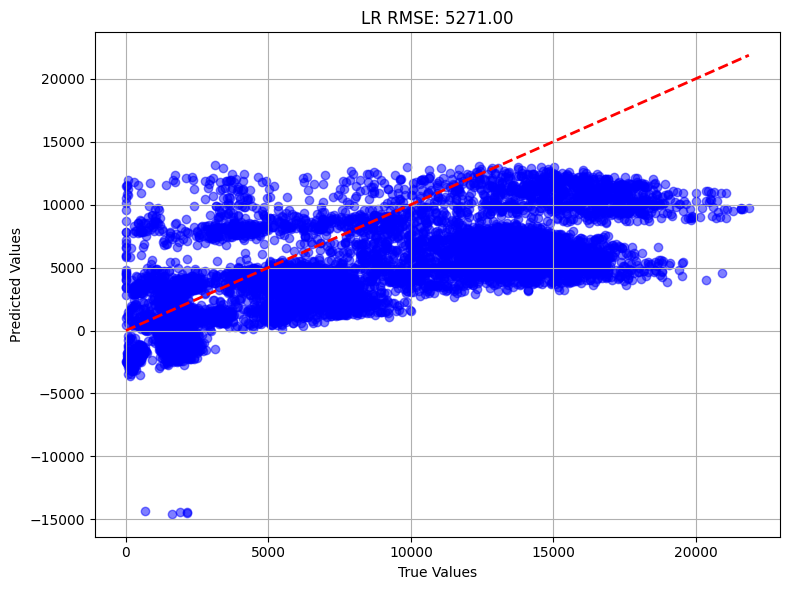

LR RMSE:  5270.997627100258
Time to fit and predict for Linear Regression: 1267.42 seconds
Peak memory usage: 1227.9609375 MB


In [127]:
def run_lr():    
# LR
    start_time = time.time()

    clf = LinearRegression() #fit_intercept=0
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred = y_pred.compute()

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    plot_predictions(
        y_test, y_pred, "LinearRegression", file_type=file_type, title=f"LR RMSE: {rmse:.2f}"
    )

    end_time = time.time()

    print("LR RMSE: ", rmse)
    print(f"Time to fit and predict for Linear Regression: {end_time - start_time:.2f} seconds")

mem_usage = memory_usage(run_lr, max_usage=True)
print(f"Peak memory usage: {mem_usage} MB")
# rmse: 3 9 5271.0
# rmse: 4 6 5244.9
#      5 5 5271.0


In [128]:
client.close()

In [129]:
cluster.close()

### XGBoost:

XGBoost results:


c:\Users\Uporabnik\.conda\envs\bdproject\Lib\site-packages\distributed\client.py:3161: UserWarning: Sending large graph of size 34.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_13620\535559124.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


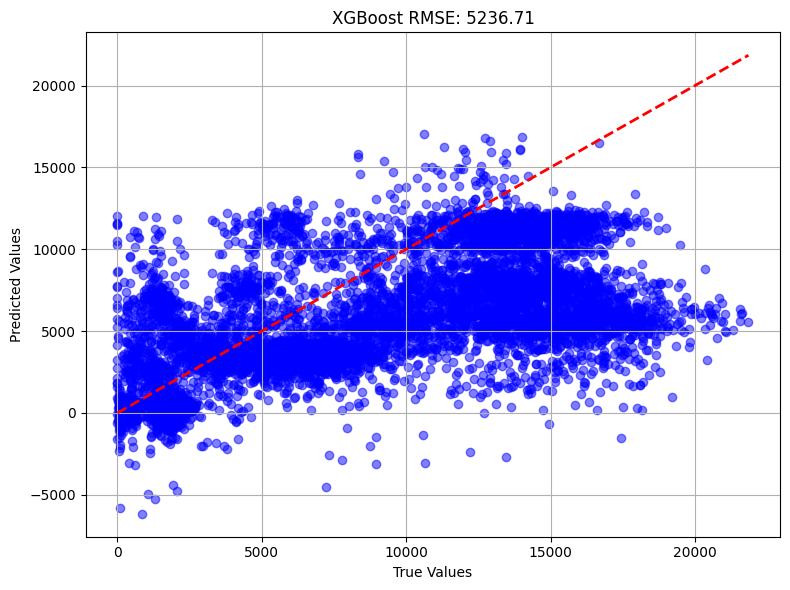

RMSE:  5236.713617679574
Time for fit and predict with XGBoost: 15.11 seconds
Peak memory usage: 849.58203125 MB


In [140]:
def run_xgboost():  
  # XGBoost
    print("XGBoost results:")
    start_time = time.time()

    clf = xgb.XGBRegressor()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    plot_predictions(y_test, y_pred, "XGBoost", file_type=file_type, title=f"XGBoost RMSE: {rmse :.2f}")
    print("RMSE: ", rmse)
    end_time = time.time()
    print(f"Time for fit and predict with XGBoost: {end_time - start_time:.2f} seconds")

mem_usage = memory_usage(run_xgboost, max_usage=True)
print(f"Peak memory usage: {mem_usage} MB")

# rmse: 3 9 5236.7
# rmse: 4 6 5327.62
# rmse: 5 5 (n_partitions=15)



In [67]:
# Set the feature names
clf.get_booster().feature_names = feature_names

NameError: name 'clf' is not defined

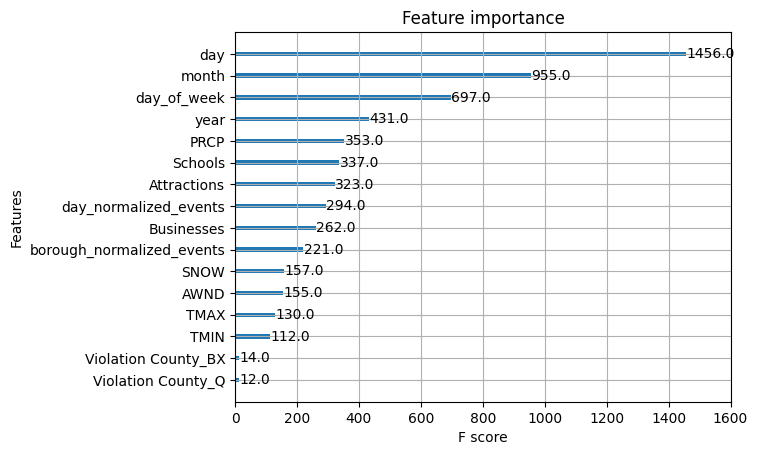

In [ ]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(clf.get_booster(), importance_type='weight')
plt.savefig(f"plots/feature_importance_daily_tickets_{split_date}_{file_type}.png", dpi=300)
pyplot.show()


### partial_fit with SGDRegressor

c:\Users\Uporabnik\.conda\envs\bdproject\Lib\site-packages\distributed\client.py:3161: UserWarning: Sending large graph of size 34.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Users\Uporabnik\.conda\envs\bdproject\Lib\site-packages\distributed\client.py:3161: UserWarning: Sending large graph of size 34.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Users\Uporabnik\.conda\envs\bdproject\Lib\site-packages\distributed\client.py:3161: UserWarning: Sending large graph of size 34.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Users\Uporabnik\.conda\envs\bdproject\Lib\site-packages\distributed\client.py:3161: UserWarning: Sending large graph of size 34.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Users\Uporabnik\.cond

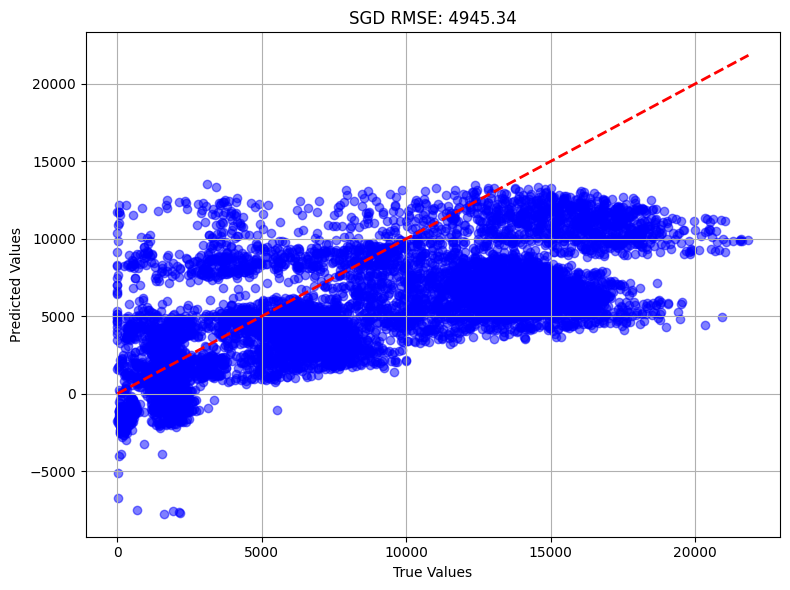

c:\Users\Uporabnik\.conda\envs\bdproject\Lib\site-packages\distributed\client.py:3161: UserWarning: Sending large graph of size 34.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Users\Uporabnik\.conda\envs\bdproject\Lib\site-packages\distributed\client.py:3161: UserWarning: Sending large graph of size 34.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Users\Uporabnik\.conda\envs\bdproject\Lib\site-packages\distributed\client.py:3161: UserWarning: Sending large graph of size 34.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Users\Uporabnik\.conda\envs\bdproject\Lib\site-packages\distributed\client.py:3161: UserWarning: Sending large graph of size 34.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Users\Uporabnik\.cond

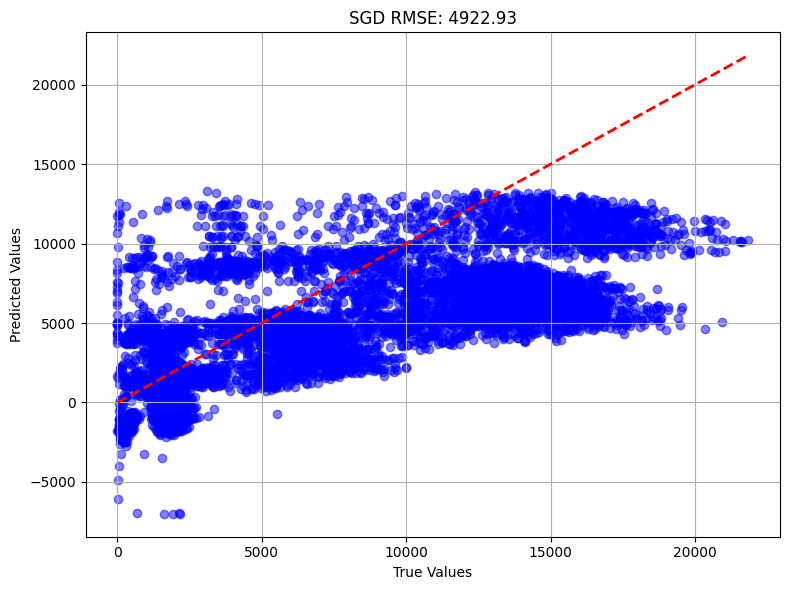

SGD RMSE: 4922.93
Time to fit and predict for SGDRegressor: 18.18 seconds
Peak memory usage: 921.45 MiB


In [141]:
def SGD_train_and_predict():
    clf = SGDRegressor()  # fit_intercept=0 if needed
    for i in range(10):
        clf.partial_fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    plot_predictions(
        y_test, y_pred, "SGDRegressor", file_type=file_type, title=f"SGD RMSE: {rmse:.2f}"
    )
    return rmse

# Measure time and memory
start_time = time.time()
mem_usage = memory_usage(SGD_train_and_predict, max_usage=True)  # Returns the maximum memory usage
end_time = time.time()

print(f"SGD RMSE: {SGD_train_and_predict():.2f}")
print(f"Time to fit and predict for SGDRegressor: {end_time - start_time:.2f} seconds")
print(f"Peak memory usage: {mem_usage:.2f} MiB")

# rmse: 3 9 4912.4
# rmse: 4 6 4880.54
# rmse: 5 5 4966.0